In [119]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=1efb003821bb2c4665f280158fd2daf0778f0092578b2fafd8e62a3c80b15a36
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [121]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from itertools import product
import japanize_matplotlib

import datetime
import matplotlib.pyplot as plt

In [99]:
#取得するデータの開始日と最終日を指定
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2024, 5, 5)

In [100]:
eq = web.DataReader('sp500', 'fred', start, end)
print(eq.index)

## データにNaNの数を確認
print(eq.isnull().sum())

## 取得したdataframeにfreqを設定
eq.index.freq = 'B'
print(eq.index)

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-13', '2020-01-14',
               ...
               '2024-04-22', '2024-04-23', '2024-04-24', '2024-04-25',
               '2024-04-26', '2024-04-29', '2024-04-30', '2024-05-01',
               '2024-05-02', '2024-05-03'],
              dtype='datetime64[ns]', name='DATE', length=1133, freq=None)
sp500    41
dtype: int64
DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-13', '2020-01-14',
               ...
               '2024-04-22', '2024-04-23', '2024-04-24', '2024-04-25',
               '2024-04-26', '2024-04-29', '2024-04-30', '2024-05-01',
               '2024-05-02', '2024-05-03'],
              dtype='datetime64[ns]', name='DATE', length=1133, freq='B')


In [101]:
eq = eq.interpolate(limit=1, limit_direction='both')
eq

,sp500
DATE,
2020-01-01,3257.85
2020-01-02,3257.85
2020-01-03,3234.85
2020-01-06,3246.28
2020-01-07,3237.18
...,...
2024-04-29,5116.17
2024-04-30,5035.69
2024-05-01,5018.39


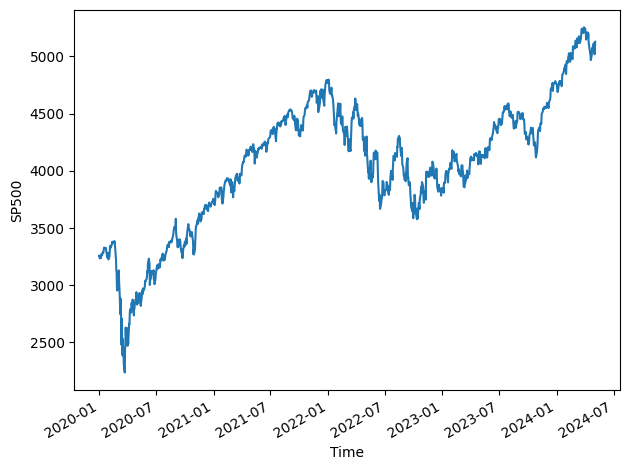

In [102]:
fig, ax = plt.subplots()

ax.plot(eq)
ax.set_xlabel('Time')
ax.set_ylabel('SP500')

fig.autofmt_xdate()
plt.tight_layout()

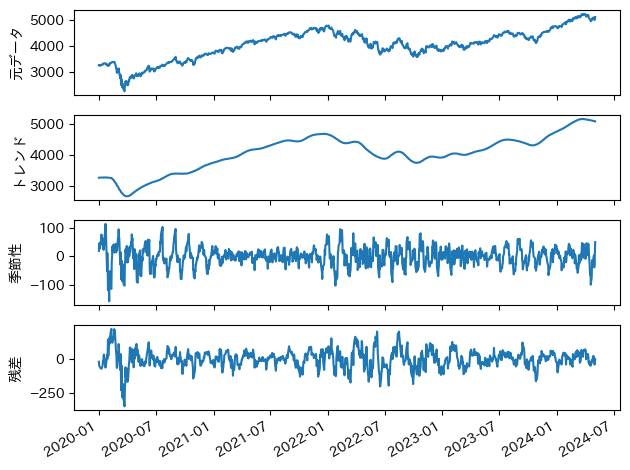

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
advanced_decomposition = STL(eq.sp500, period=30).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('元データ')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('トレンド')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('季節性')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('残差')


fig.autofmt_xdate()
plt.tight_layout()

In [104]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(eq)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.0441385465691715
p-value: 0.7368274668682403


In [105]:
eq_diff = np.diff(eq['sp500'], n=1)

ad_fuller_result = adfuller(eq_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -10.097617737644452
p-value: 1.080382119903209e-17


In [106]:
eq_diff_log = np.log(eq['sp500']).diff()

eq_diff_log = eq_diff_log.dropna(how='all')

ad_fuller_result = adfuller(eq_diff_log)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -9.777745825992286
p-value: 6.862506876022706e-17


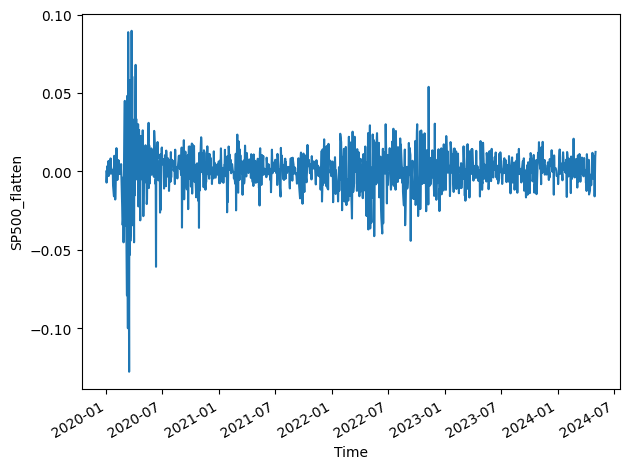

In [107]:
fig, ax = plt.subplots()

ax.plot(eq_diff_log)
ax.set_xlabel('Time')
ax.set_ylabel('SP500_flatten')

fig.autofmt_xdate()
plt.tight_layout()

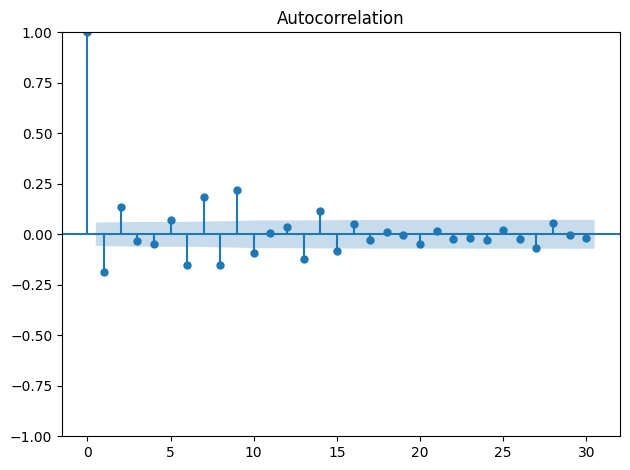

In [108]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(eq_diff_log, lags=30)
plt.tight_layout()

In [109]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from typing import Union

def optimize_ARIMA(data, order_list, d):
  results = []

  for order in order_list:
    try:
      model = SARIMAX(data, order=(order[0], d, order[1]), freq='B').fit(disp=False)
    except:
      continue

    aic = model.aic
    results.append([order, aic])

  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,q)', 'AIC']

  return result_df


In [110]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

train = eq['sp500'][:-300]

result_df = optimize_ARIMA(train, order_list, d)
result_df.sort_values(by='AIC')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

,"(p,q)",AIC
10,"(2, 2)",8902.421679
11,"(2, 3)",8903.278197
14,"(3, 2)",8903.402195
15,"(3, 3)",8906.110448
8,"(2, 0)",8928.816677
2,"(0, 2)",8929.474094
5,"(1, 1)",8929.606365
3,"(0, 3)",8929.852932
6,"(1, 2)",8930.462886
12,"(3, 0)",8930.512118


In [111]:
model = SARIMAX(train, order=(2,1,2), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sp500   No. Observations:                  833
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -4446.211
Date:                Sat, 04 May 2024   AIC                           8902.422
Time:                        06:08:57   BIC                           8926.041
Sample:                    01-01-2020   HQIC                          8911.478
                         - 03-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7310      0.040    -42.955      0.000      -1.810      -1.652
ar.L2         -0.8787      0.038    -22.832      0.000      -0.954      -0.803
ma.L1          1.6278      0.050     32.305      0.0

In [112]:
## テストデータの株価を指定日数ごとに分けて小分けに予測する。
def rolling_forecast(df, train_len, test_len, window, p, d, q):

    total_len = train_len + test_len

    pred_ARMA = []

    ## トレーニングデータ以降を始点としてテストデータをwindowで指定した数ごとに分けてループする。
    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order=(p,d,q))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]
      pred_ARMA.extend(oos_pred)

    return pred_ARMA

In [113]:
# テストデータを取得
test = eq['sp500'][-300:]

TRAIN_LEN = len(train)
TEST_LEN = len(test)

# 3日ごとに予測
WINDOW = 3
# 次元p,qはAICで調べた値を代入
P = 2
Q = 2
# 次元d定常化を実施した回数を代入
D = 1

pred_ARIMA = rolling_forecast(eq, TRAIN_LEN, TEST_LEN, WINDOW, P, D, Q)

test = pd.DataFrame({'test': test})
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,test,pred_ARIMA
DATE,,
2023-03-13,3855.76,3863.600216
2023-03-14,3919.29,3859.158376
2023-03-15,3891.93,3865.080575
2023-03-16,3960.28,3893.327756
2023-03-17,3916.64,3895.385248
...,...,...
2024-04-29,5116.17,5049.640381
2024-04-30,5035.69,5041.882499
2024-05-01,5018.39,5048.423180


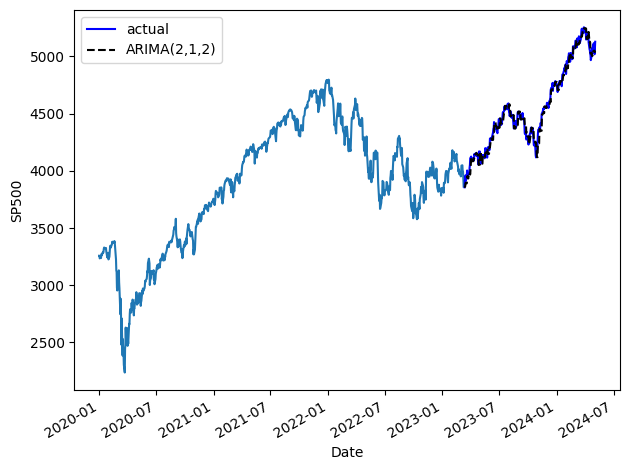

In [114]:
fig, ax = plt.subplots()

ax.plot(train)
ax.plot(test['test'], 'b-', label='actual')
ax.plot(test['pred_ARIMA'], 'k--', label='ARIMA(2,1,2)')

ax.set_xlabel('Date')
ax.set_ylabel('SP500')

ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

In [115]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_ARIMA = sqrt(mean_squared_error(test['test'], test['pred_ARIMA']))

print(rmse_ARIMA)

48.7000032390795


In [125]:
test = eq['sp500'][-300:]

# 直近の株価(テストデータで使用した株価)をもとに未来9日の株価を予測する。
TRAIN_LEN = len(test)
FORECAST = 9

# 3日ごとに予測をする。
WINDOW=3

forecast_ARIMA = rolling_forecast(test, TRAIN_LEN, FORECAST, WINDOW, P, D, Q)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [126]:
# 予測結果を表示する。
forecast_ARIMA

[5132.465958176647,
 5121.243292775922,
 5111.887312268979,
 5119.120914509795,
 5131.456727245128,
 5129.4389287601625,
 5116.3281644544,
 5112.835298968645,
 5124.405217875408]